<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.1.0
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install diffusers
!pip install tqdm
!pip install accelerate

In [ ]:
from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

import torch
import math
import numpy as np

from torch import nn
from torch.nn import functional as F
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
from ipdb import set_trace as st
from functools import partial
from torch import optim
from torch.optim import lr_scheduler

from torchvision import transforms
from pathlib import Path
from tqdm import tqdm

from torch.cuda.amp import GradScaler
from torch import autocast
import time
import numpy
from accelerate import Accelerator
import requests
import io
from PIL import Image

import timm

In [ ]:
def load_image(url, target_size = (512, 512), headers = {}):
  image = Image.open(io.BytesIO(requests.get(url, headers = headers).content)).resize(target_size)
  content_im = transforms.PILToTensor()(image)
  if float(content_im.max()) > 1.: content_im = (content_im - content_im.min())/(content_im.max() - content_im.min())
  return content_im

class DummyDS(Dataset):
  def __init__(self, n = 100, y = None): self.n = n; self.y = y
  def __len__(self): return self.n
  def __getitem__(self, index): return 0., self.y

def get_dummy_dls(n = 100, y = None): return DataLoaders(DataLoader(DummyDS(100, y = y), batch_size = 1), DataLoader(DummyDS(20, y = y), batch_size = 1))

class StyleTransferModel(nn.Module):
  def __init__(self, w = None, size = (1, 3, 512, 512)):
    super().__init__()
    self.w = nn.Parameter(w.clone()) if w is not None else nn.Parameter(torch.randn(size))

  def forward(self, x):
    return self.w

class ImageMonitoringCB(Callback):
  ProgressCB.order += 1
  def __init__(self, log_every = 20):
    self.log_every = log_every
    self.preds = []
    self.i = 0

  def after_batch(self, learn):
    if not learn.training: return
    if self.i%self.log_every == 0: self.preds.append(learn.preds.detach().clone().squeeze().cpu().clip(0., 1.))
    self.i += 1

def store_hooks(mod, inp, out, obj): obj._data = out

class Hook:
  def __init__(self, module):
    self._data = None
    self.module = module
    self.module.register_forward_hook(partial(store_hooks, obj = self))

  def clear(self): self._data = None

  @property
  def data(self):
    try: return self._data
    finally: self.clear()


class PerceptLoss():
  def __init__(self, layers = (18, 25), metric = nn.MSELoss(), device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), model = 'vgg16'):
    self.device = device
    self.net = timm.create_model(model, pretrained= True).features.to(device)
    self.means = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
    self.std = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)
    self.hooks = [Hook(self.net[i]) for i in layers]
    self.metric = metric

  def normalize(self, data): return (data - self.std)/self.means

  def __call__(self, yhat, y):
    loss = 0.
    out = self.net(self.normalize(torch.cat([yhat, y], dim = 0)))
    for i in [self.metric(i.data[0], i.data[1]) for i in self.hooks]: loss += i
    return loss

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class NormCB(Callback):
  DeviceCB.order += 10
  def after_loss(self, learn):
    with torch.no_grad(): learn.w = (learn.model.w - learn.model.w.mean())/learn.model.w.std()

def norm(x): return (x - x.mean())/x.std()

def channel_wise_similarity(inp, targ):
  inp, targ = norm(inp), norm(targ)
  return -1*(torch.einsum('nhw, nhw -> n', inp, targ)/inp.shape[0]).mean()

def calc_grams(inp, targ):
  h, w = inp.shape[-2], inp.shape[-1]
  a = torch.stack((norm(inp), norm(targ)))
  out = torch.einsum('bchw, bdhw -> bcd', a, a)/(h*w)
  return out[0], out[1]

def calc_mse(inp, targ):
  return (inp - targ).pow(2).mean()

def calc_gram_mse(inp, targ):
  inp_g, targ_g = calc_grams(inp, targ)
  return calc_mse(inp_g, targ_g)

class MultipleLosses:
  def __init__(self, losses = (nn.MSELoss(), calc_gram_mse), coeffs = (0.2, 0.8)): fc.store_attr()
  def __call__(self, inp, targ):
    loss = 0.
    for c, lf in zip(self.coeffs, self.losses): loss += c*lf(inp, targ)
    return loss

In [ ]:
class PerceptLossV2(PerceptLoss):
  def __init__(self, target, layers = (18, 25), metric = nn.MSELoss(), device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), model = 'vgg16'):
    super().__init__(layers, metric, device, model)
    self.target_grams = self.get_grams(target)

  def do_forward(self, inp):
    x = inp
    if len(x.shape) < 4: x = x[None, :, :, :]
    if x.device != self.device: x = x.to(self.device)
    self.net(self.normalize(x))

  def calculate_grams(self, acts):
    # Make sure that we calculate grams after do_forward
    h, w = acts.shape[-2], acts.shape[-1]
    return torch.einsum('bchw, bdhw -> bcd', acts, acts)/(h*w)

  def get_grams(self, inp):
    self.do_forward(inp)
    return [self.calculate_grams(i.data) for i in self.hooks]

  def __call__(self, yhat):
    self.do_forward(yhat)
    loss = 0.
    for h, t_gram in zip(self.hooks, self.target_grams): loss += self.metric(self.calculate_grams(h.data), t_gram)
    return loss

def store_hooks(mod, inp, out, obj): obj.data = out

class Hook:
  def __init__(self, module):
    self.data = None
    self.module = module
    self.module.register_forward_hook(partial(store_hooks, obj = self))


In [ ]:
content_im = load_image('https://images.pond5.com/vector-slime-blob-liquid-drop-illustration-199791015_iconl_nowm.jpeg', (128, 128))

In [ ]:
lf = PerceptLossV2(content_im, layers = (1, 6, 11, 18, 25), metric = calc_mse)

<Axes: >

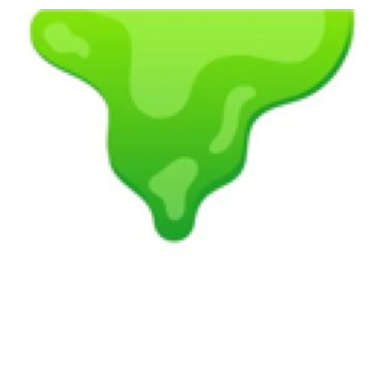

In [ ]:
show_image(content_im)

In [ ]:
inp = torch.randn((4, 3, 512, 512))
loss = lf(inp)

In [ ]:
# Step - 1 - Make Grids
# Step - 2 - Class to extract states of each pixels
# Step - 3 - A model to take in a extracted states of each pixels and return an updated state of the grid. - There is no step
# Step - 4 - Modified learner that just does 50 iterations every time

In [ ]:
num_channels = 4
grid_size = 128
def make_grids(n = 1, gs = grid_size): return torch.randn(n, num_channels, gs, gs)

In [ ]:
x = torch.randn(1, 4, 10, 10)
inp = x.view(4, 1, 10, 10)
filters = torch.stack([
        torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
        torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
    ])

out = F.conv2d(input = inp, weight = filters[:, None, :,  :], stride = 1)

In [ ]:
# Extract States
class StateExtractor:
  def __init__(self):
    self.filters = torch.stack([
        torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
        torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
        torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
    ]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

  def __call__(self, x):
    # x - bs, ch, gs, gs - bs*ch, 1, gs, gs
    bs, ch, h, w = x.shape
    inp = x.view(bs*ch, 1, h, w)

    # Pad the input
    inp = F.pad(inp, [1, 1, 1, 1], 'circular')

    # (out_channels, in_channels , kernel_height, kernel_width)
    out = F.conv2d(inp, self.filters[:, None, :, :])
    return out.view(bs, -1, h, w)

In [ ]:
# TODO - Understand
import torchvision
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return

        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(torch.tensor(self.losses).min(), self.losses[0])

        # Show preview images:
        rgb = to_rgb(learn.preds.detach().cpu()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])

        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [ ]:
class Net(nn.Module):
  def __init__(self, nin = num_channels*4, nout = num_channels, n_hidden = 8, update_pct = 0.5):
    super().__init__()
    self.update_pct = update_pct
    self.state_extractor = StateExtractor()
    self.net = nn.Sequential(nn.Conv2d(nin, n_hidden, 1, 1), nn.ReLU(), nn.Conv2d(n_hidden, nout, 1, 1, bias = False)).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    self.net[-1].weight.data.zero_()

  def forward(self, x):
    if x.device != torch.device('cuda' if torch.cuda.is_available() else 'cpu'): x = x.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    u = self.net(self.state_extractor(x))
    update_mask = (torch.randn(x.shape) > self.update_pct).float().to(x.device)
    return x + update_mask*u

In [ ]:
def to_rgb(x): return x[...,:3,:,:]+0.5 # TODO

class NCALoss:
  def __init__(self, target = content_im):

    # Two losses -
    #    1. Gram Loss
    #.   2. Overflow Loss
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.gram_lf = PerceptLossV2(content_im, layers = (1, 6, 11, 18, 25), metric = calc_mse)
    # self.target = content_im.to(self.device)

  def __call__(self, x):
    if x.device != self.device: x = x.to(self.device)
    return self.gram_lf(to_rgb(x)) + (x - x.clamp(-1., 1.)).abs().sum()

In [ ]:
bs = 4
class NCALearner(TrainLearner):
  def __init__(self, *args, style_loss_scale=0.1, size=256, step_n_min=32, step_n_max=96, batch_size=4, **kwargs):
    super().__init__(*args, **kwargs)
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.step_n_min, self.step_n_max, self.bs, self.size = step_n_min, step_n_max, batch_size, size
    with torch.no_grad(): self.pool = make_grids(size, grid_size).to(self.device)

  def predict(self):
    #self.preds = self.model(self.batch[0])
    # step - 1 choose some random batch of input from pool
    random_idxs = torch.randint(0, self.size, (self.bs,))
    x = self.pool[random_idxs] # 4 * 4 * 128 * 128

    # step - 1b - Occasionally zero out some samples from the batch choosen from pool
    # if torch.randint(0, 9, (1,))[0] % 8 == 0: x[:1] =  make_grids(1, sz=self.size)

    # step - 2 Iteratively update the state of input for random number of times by calling the model
    for i in range(torch.randint(self.step_n_min, self.step_n_max, (1,))[0]): x = self.model(x)

    # step - 3 Update the pool with the updated states.
    with torch.no_grad(): self.pool[random_idxs] = x
    self.preds = x

  def get_loss(self): self.loss = self.loss_func(self.preds)

  def backward(self):
    self.loss.backward(retain_graph=True)
    # Gradient Norm
    for p in self.model.parameters(): p.grad /= (p.grad.norm()+1e-8)

In [ ]:
model = Net()
lf = NCALoss(target = content_im)
cbs = [DeviceCB(torch.device('cuda')), NCAProgressCB(), MetricsCB()]
learn = NCALearner(model, get_dummy_dls(1200, y = content_im), lf, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
1458.679,0,train
0.088,0,eval
0.078,1,train
0.076,1,eval


<ipython-input-116-965dd3bdcef7>:15: UserWarning: Using a target size (torch.Size([1, 3, 128, 128])) that is different to the input size (torch.Size([4, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 0.0*self.gram_lf(to_rgb(x)) + (x - x.clamp(-1., 1.)).abs().sum() + 1.0*F.mse_loss(to_rgb(x), self.target[None, :])


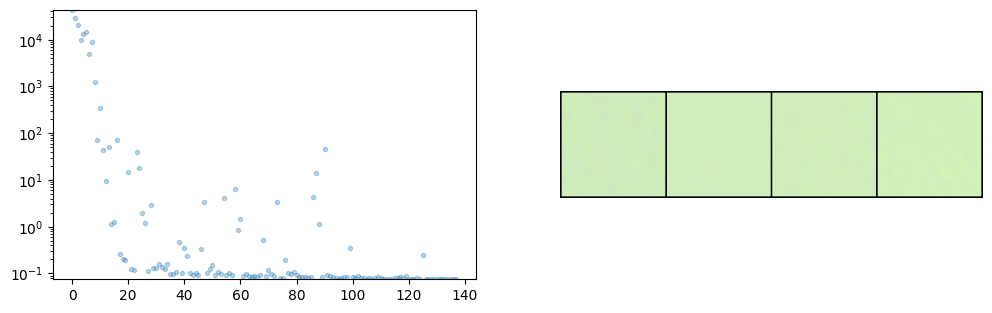

In [ ]:
learn.fit(2)

In [ ]:
lf = None
model = None
learner = None

import gc
gc.collect()
torch.cuda.empty_cache()

<Axes: >

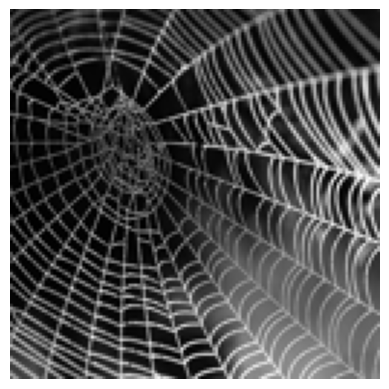

In [ ]:
content_im = load_image('https://insideecology.com/wp-content/uploads/2018/06/spider-web-with-water-beads-921039_1280.jpg', (128, 128))
show_image(content_im)

loss,epoch,train
4475.332,0,train
162.689,0,eval
166.895,1,train
163.805,1,eval
150.306,2,train
109.928,2,eval
116.491,3,train
88.156,3,eval
158.638,4,train
77.527,4,eval


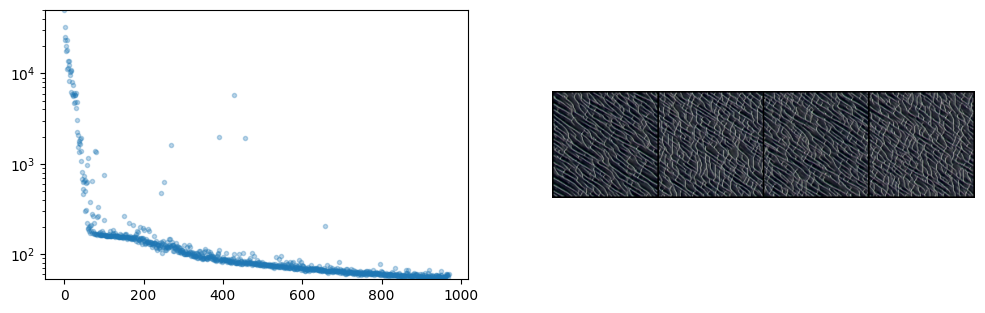

In [ ]:
model = Net()
lf = NCALoss(target = content_im)
cbs = [DeviceCB(torch.device('cuda')), NCAProgressCB(), MetricsCB()]
learn = NCALearner(model, get_dummy_dls(1200, y = content_im), lf, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(10)